In [9]:
import codecs,unidecode
import ruamel_yaml as yaml
import pandas as pd
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
import pyperclip,re
from IPython.display import display,HTML
import EspacesThematiques as ET
from EspacesThematiques import *


In [10]:
brutLex=False

In [11]:
%matplotlib inline

In [12]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("hls")
sns.set_color_codes("muted")
#sns.palplot(sns.color_palette("hls", 8))
#sns.palplot(sns.color_palette("husl", 8))

repFigs="/Users/gilles/ownCloud/Recherche/Boye/HDR/Memoire/figs/"

In [13]:
if brutLex:
    fLexFilms4="Lexique4-Brut.tsv"
    colLex4="graphie lemme cat occurrences".split(" ")
    csvHeader=None
else:
    fLexFilms4="Lexique4.tsv"
    colLex4="graphie lemme cat infover genre nombre occurrences".split(" ")
    csvHeader=1

In [14]:
dfLexFilms4=pd.read_csv(filepath_or_buffer=fLexFilms4,sep="\t",header=csvHeader,skip_blank_lines=True,encoding="utf8")
dfLexFilms4.columns=colLex4

In [15]:
dfLex4=dfLexFilms4.sort_values(["lemme","cat"]).reset_index().drop(columns="index")

In [16]:
dfLex4["rangFW"]=dfLex4["occurrences"].rank(ascending=False)
dfLex4=dfLex4[dfLex4["cat"].notnull()].sort_values("rangFW").reset_index().drop(columns="index")
dfLex4.head()

,graphie,lemme,cat,infover,genre,nombre,occurrences,rangFW
0,de,de,PRE,NaN,NaN,NaN,8309303.0,1.0
1,je,je,PRO:per,NaN,NaN,s,8185113.0,2.0
2,est,être,VER,ind:pre:3,NaN,s,6080693.0,3.0
3,pas,pas,ADV,NaN,NaN,NaN,5709800.0,4.0
4,vous,vous,PRO:per,NaN,NaN,p,4431441.0,5.0


In [17]:
if brutLex:
    dfLex4.columns=[u'graphie', u'lemme', u'TAG', u'occurrences', u'rangFW']
    dfLex4.loc[dfLex4.TAG.str.startswith(u"Vm"),"cat"]="VER"
    dfLex4.loc[dfLex4.TAG.str.startswith(u"Nc"),"cat"]="NOM"
    dfLex4.loc[dfLex4.TAG.str.startswith(u"Af"),"cat"]="ADJ"
    dfLex4

# Comparaison de la distribution des fréquences avec Zipf

In [18]:
#
# Adapted from
# https://stackoverflow.com/questions/43837179/best-fit-line-on-log-log-scales-in-python-2-7/43838500
#
def plotZipf(lDF,rankColumn,graphLabel=u"Formes dans Films",lQuartiles=["All"]):
    fig=plt.figure()
    ax = fig.add_subplot(111)

    lRang=lDF[rankColumn]
    lOccurrences=lDF["occurrences"]

    logOccurrences=np.log(lOccurrences)
    logRang=np.log(lRang)
    lQuart=len(logRang)/4

    mAll, cAll = np.polyfit(logRang, logOccurrences, 1)
    yZipfGen = np.exp(mAll*logRang + cAll)
    mQ1, cQ1 = np.polyfit(logRang[:lQuart], logOccurrences[:lQuart], 1)
    yZipfQ1 = np.exp(mQ1*logRang + cQ1)
    mQ2, cQ2 = np.polyfit(logRang[lQuart:2*lQuart], logOccurrences[lQuart:2*lQuart], 1)
    yZipfQ2 = np.exp(mQ2*logRang + cQ2)
    mQ3, cQ3 = np.polyfit(logRang[2*lQuart:3*lQuart], logOccurrences[2*lQuart:3*lQuart], 1)
    yZipfQ3 = np.exp(mQ3*logRang + cQ3)
    mQ4, cQ4 = np.polyfit(logRang[3*lQuart:], logOccurrences[3*lQuart:], 1)
    yZipfQ4 = np.exp(mQ4*logRang + cQ4)
    
    print u"Coefficient général %0.2f\n\tQ1 %0.2f\n\tQ2 %0.2f\n\tQ3 %0.2f\n\tQ4 %0.2f"%(mAll, mQ1, mQ2, mQ3, mQ4)

    plt.plot(lRang, lOccurrences,label='_nolegend_')
    if "All" in lQuartiles:
        plt.plot(lRang, yZipfGen,":",label="All")
    if "Q1" in lQuartiles:
        plt.plot(lRang, yZipfQ1, ':',label="Q1")
    if "Q2" in lQuartiles:
        plt.plot(lRang, yZipfQ2, ':',label="Q2")
    if "Q3" in lQuartiles:
        plt.plot(lRang, yZipfQ3, ':',label="Q3")
    if "Q4" in lQuartiles:
        plt.plot(lRang, yZipfQ4, ':',label="Q4")

    ax.set_yscale('log')
    ax.set_xscale('log')
    #slope, intercept = np.polyfit(logA, logB, 1)
    plt.xlabel("Rang")
    plt.ylabel("Occurrences")
    ax.set_title(graphLabel)
    ax.legend()
    plt.show()

## Comparaison de l'ensemble du lexique
le coefficient de Zipf varie du simple au double entre le premier quartile 1.56 et le dernier 3.70

Coefficient général -2.25
	Q1 -1.54
	Q2 -2.73
	Q3 -3.56
	Q4 -3.94


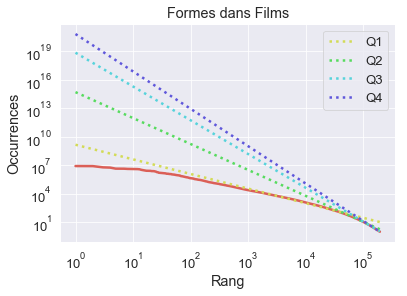

In [19]:
plotZipf(dfLex4,"rangFW",lQuartiles="Q1 Q2 Q3 Q4".split(" "))

## Comparaisons par catégories

In [20]:
dfL4={}

catV=["VER","AUX"]
dfVerbes4=dfLex4.loc[dfLex4["cat"].isin(catV),:]
dfVerbes4.loc[dfVerbes4["cat"].isin(catV),"rangFWV"]=dfVerbes4.loc[dfVerbes4["cat"].isin(catV),"occurrences"].rank(ascending=False)
dfL4["V"]=dfVerbes4.sort_values("rangFWV").reset_index().drop(columns="index")

dfNoms4=dfLex4.loc[dfLex4["cat"]=="NOM",:]
dfNoms4.loc[dfNoms4["cat"]=="NOM","rangFWN"]=dfNoms4.loc[dfNoms4["cat"]=="NOM","occurrences"].rank(ascending=False)
dfL4["N"]=dfNoms4.sort_values("rangFWN").reset_index().drop(columns="index")

dfAdjectifs4=dfLex4.loc[dfLex4["cat"]=="ADJ",:]
dfAdjectifs4.loc[dfAdjectifs4["cat"]=="ADJ","rangFWA"]=dfAdjectifs4.loc[dfAdjectifs4["cat"]=="ADJ","occurrences"].rank(ascending=False)
dfL4["A"]=dfAdjectifs4.sort_values("rangFWA").reset_index().drop(columns="index")

for cat in "VNA":
    print cat
    display(dfL4[cat].head())

/Users/gilles/anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/gilles/anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


V


,graphie,lemme,cat,infover,genre,nombre,occurrences,rangFW,rangFWV
0,est,être,VER,ind:pre:3,NaN,s,6080693.0,3.0,1.0
1,a,avoir,AUX,ind:pre:3,NaN,s,2139655.0,25.0,2.0
2,ai,avoir,AUX,ind:pre:1,NaN,s,1641324.0,28.0,3.0
3,a,avoir,VER,ind:pre:3,NaN,s,1528403.0,32.0,4.0
4,est,être,AUX,ind:pre:3,NaN,s,1030580.0,52.0,5.0


N


,graphie,lemme,cat,infover,genre,nombre,occurrences,rangFW,rangFWN
0,chose,chose,NOM,NaN,f,s,494041.0,92.0,1.0
1,temps,temps,NOM,NaN,m,NaN,354682.0,118.0,2.0
2,besoin,besoin,NOM,NaN,m,s,332955.0,126.0,3.0
3,accord,accord,NOM,NaN,m,s,307709.0,134.0,4.0
4,vie,vie,NOM,NaN,f,s,303957.0,135.0,5.0


A


,graphie,lemme,cat,infover,genre,nombre,occurrences,rangFW,rangFWA
0,juste,juste,ADJ,NaN,NaN,s,323706.0,130.0,1.0
1,bon,bon,ADJ,NaN,m,s,297776.0,141.0,2.0
2,tout,tout,ADJ,NaN,m,s,286396.0,146.0,3.0
3,tous,tout,ADJ,NaN,m,p,282538.0,148.0,4.0
4,sûr,sûr,ADJ,NaN,m,s,267518.0,155.0,5.0


On peut calculer le ratio entre le coefficient du premier quartile et celui du quatrième.
- pour les verbes, Q4/Q1=2.05
- pour les noms, Q4/Q1=3.03
- pour les adjectifs, Q4/Q1=3.48

V
Coefficient général -2.14
	Q1 -1.54
	Q2 -2.55
	Q3 -3.14
	Q4 -3.38


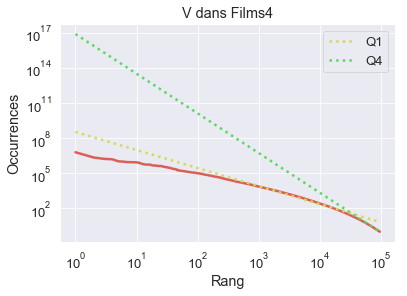

N
Coefficient général -2.36
	Q1 -1.39
	Q2 -3.05
	Q3 -4.09
	Q4 -4.72


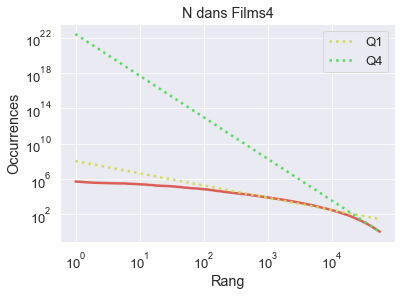

A
Coefficient général -2.04
	Q1 -1.28
	Q2 -2.47
	Q3 -3.62
	Q4 -4.53


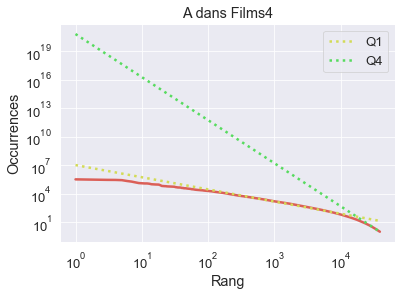

In [21]:
for cat in "VNA":
    print cat
    plotZipf(dfL4[cat],"rangFW%s"%cat,graphLabel="%s dans Films4"%cat,lQuartiles="Q1 Q4".split(" "))

# Statistiques sur les cases du paradigme morphosyntaxique

## Filtrer les scories de Lexique4
- quelques formes fléchies sont notées avec des lemmes qui ne correspondent pas à un verbe
- quelques formes ne sont pas identifiées : infover = NaN
- une forme est indiquée comme impératif 3S

Dans tous les cas, on remplace l'étiquette de Lexique.org par l'étiquette Grace

In [22]:
dfL4["V"].infover.unique()

array([u'ind:pre:3', u'ind:pre:1', u'inf;', u'ind:imp:3', u'ind:pre:2',
       u'par:pas:', u'imp:pre:2', u'inf', u'ind:imp:1', u'ind:fut:3',
       u'cnd:pre:3', u'sub:pre:3', u'imp:pre:1', u'cnd:pre:1', nan,
       u'cnd:pre:2', u'ind:imp:2', u'ind:fut:1', u'par:pre', u'ind:fut:2',
       u'sub:pre:2', u'ind:pas:3', u'sub:pre:1', u'ind:pas:1',
       u'ind:pas:2', u'imp:pre:2s;ind:pre:1s;ind:pre:3s;sub:pre:3s;',
       u'imp:pre:2p;ind:pre:2p;par:pas;', u'imp:pre:1p;ind:pre:1p;',
       u'sub:imp:3', u'ind:pas:3s;', u'sub:imp:1', u'imp:pre:3',
       u'sub:imp:2'], dtype=object)

In [23]:
def infover2Case(lRow):
    result=""
    lInfover=lRow["infover"]
    lNombre=lRow["nombre"]
    if isinstance(lInfover,unicode):
        if lInfover in [u'imp:pre:2p;ind:pre:2p;par:pas;',
       u'imp:pre:2s;ind:pre:1s;ind:pre:3s;sub:pre:3s;',
       u'imp:pre:1p;ind:pre:1p;']:
            print lRow["graphie"],lRow["lemme"]
        else:
            if lInfover[:3]==u"inf":
                result=u"inf"
            elif lInfover==u"par:p":
                result="pP"
            elif lInfover[:8]==u"par:pas:":
                if lNombre in ["s","p"]:
                    lNombre=lNombre.upper()
                else:
                    print lRow
                lGenre=lRow["genre"]
                if lGenre in ["m","f"]:
                    lGenre=lGenre.upper()
                else:
                    print lRow
                result="pp"+lGenre+lNombre
            else:
                if lNombre in ["s","p"]:
                    lNombre=lNombre.upper()
                    if lInfover[:8]==u"ind:pre:":
                        result="pi"+lInfover[8]+lNombre
                    elif  lInfover[:8]==u"ind:imp:":
                        result="ii"+lInfover[8]+lNombre
                    elif  lInfover[:8]==u"ind:fut:":
                        result="fi"+lInfover[8]+lNombre
                    elif  lInfover[:8]==u"ind:pas:":
                        result="ai"+lInfover[8]+lNombre
                    elif  lInfover[:8]==u"imp:pre:":
                        result="pI"+lInfover[8]+lNombre
                    elif  lInfover[:8]==u"sub:pre:":
                        result="ps"+lInfover[8]+lNombre
                    elif  lInfover[:8]==u"sub:imp:":
                        result="is"+lInfover[8]+lNombre
                    elif  lInfover[:8]==u"cnd:pre:":
                        result="pc"+lInfover[8]+lNombre
                else:
                    print lRow               
    return result

print "Problèmes de lemme"
dfL4["V"]["case"]=dfL4["V"].apply(infover2Case,axis=1)

Problèmes de lemme
graphie        maintenant
lemme           maintenir
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences         29608
rangFW                852
rangFWV               301
Name: 300, dtype: object
graphie          étant
lemme             être
cat                AUX
infover        par:pre
genre              NaN
nombre             NaN
occurrences      14494
rangFW            1543
rangFWV            556
Name: 555, dtype: object
graphie        attendant
lemme           attendre
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences        13202
rangFW              1673
rangFWV              610
Name: 609, dtype: object
graphie        faisant
lemme            faire
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences      11986
rangFW            1814
rangFWV            666
Name: 665, dtype: object
graphie 

graphie        montant
lemme           monter
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences        665
rangFW           14730
rangFWV           5651
Name: 5652, dtype: object
graphie        dansant
lemme           danser
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences        632
rangFW         15244.5
rangFWV         5849.5
Name: 5850, dtype: object
graphie        correspondant
lemme           correspondre
cat                      VER
infover              par:pre
genre                    NaN
nombre                   NaN
occurrences              628
rangFW                 15297
rangFWV               5868.5
Name: 5864, dtype: object
graphie        mourant
lemme           mourir
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences        625
rangFW         15344.5
rangFWV           5885
Name: 5886, dtype: object
graphie       

Name: 8682, dtype: object
graphie        observant
lemme           observer
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences          332
rangFW             22370
rangFWV             8708
Name: 8699, dtype: object
graphie        appuyant
lemme           appuyer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences         331
rangFW          22411.5
rangFWV            8727
Name: 8721, dtype: object
graphie        effrayant
lemme           effrayer
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences          329
rangFW           22490.5
rangFWV           8758.5
Name: 8760, dtype: object
graphie        mentant
lemme           mentir
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences        329
rangFW         22490.5
rangFWV         8758.5
Name: 8762, dtype: obje

graphie        remplaçant
lemme           remplacer
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences           203
rangFW            29314.5
rangFWV             11557
Name: 11569, dtype: object
graphie        formant
lemme           former
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences        202
rangFW         29387.5
rangFWV          11589
Name: 11585, dtype: object
graphie        avançant
lemme           avancer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences         202
rangFW          29387.5
rangFWV           11589
Name: 11593, dtype: object
graphie        examinant
lemme           examiner
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences          202
rangFW           29387.5
rangFWV            11589
Name: 11594, dtype: object
graphie   

Name: 14160, dtype: object
graphie        jugeant
lemme            juger
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences        138
rangFW         35694.5
rangFWV        14277.5
Name: 14259, dtype: object
graphie        négligeant
lemme            négliger
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences           138
rangFW            35694.5
rangFWV           14277.5
Name: 14297, dtype: object
graphie        exposant
lemme           exposer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences         137
rangFW          35820.5
rangFWV           14328
Name: 14311, dtype: object
graphie        exprimant
lemme           exprimer
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences          137
rangFW           35820.5
rangFWV            14328
Name: 1432

graphie        témoignant
lemme           témoigner
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences           103
rangFW              41209
rangFWV           16604.5
Name: 16603, dtype: object
graphie        caressant
lemme           caresser
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences          102
rangFW             41395
rangFWV          16697.5
Name: 16654, dtype: object
graphie        prononçant
lemme           prononcer
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences           102
rangFW              41395
rangFWV           16697.5
Name: 16672, dtype: object
graphie        avouant
lemme           avouer
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences        102
rangFW           41395
rangFWV        16697.5
Name: 16703, dtype:

graphie        assumant
lemme           assumer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences          79
rangFW            46553
rangFWV           18993
Name: 18961, dtype: object
graphie        exerçant
lemme           exercer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences          79
rangFW            46553
rangFWV           18993
Name: 18969, dtype: object
graphie         virant
lemme            virer
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences         79
rangFW           46553
rangFWV          18993
Name: 18984, dtype: object
graphie        planant
lemme           planer
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences         79
rangFW           46553
rangFWV          18993
Name: 18985, dtype: object
graphie        mentionnant
lemme           men

Name: 21345, dtype: object
graphie        étranglant
lemme           étrangler
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences            63
rangFW              51576
rangFWV             21315
Name: 21391, dtype: object
graphie        surgissant
lemme              surgir
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences            62
rangFW            51931.5
rangFWV           21480.5
Name: 21422, dtype: object
graphie        ravissant
lemme              ravir
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences           62
rangFW           51931.5
rangFWV          21480.5
Name: 21425, dtype: object
graphie        pleurnichant
lemme           pleurnicher
cat                     VER
infover             par:pre
genre                   NaN
nombre                  NaN
occurrences              62
ran

graphie        sanglant
lemme           sangler
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences          49
rangFW            57362
rangFWV         23933.5
Name: 23942, dtype: object
graphie        grognant
lemme           grogner
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences          49
rangFW            57362
rangFWV         23933.5
Name: 23991, dtype: object
graphie        prévoyant
lemme            prévoir
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences           48
rangFW           57862.5
rangFWV          24161.5
Name: 24044, dtype: object
graphie        épatant
lemme           épater
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences         48
rangFW         57862.5
rangFWV        24161.5
Name: 24059, dtype: object
graphie        conseillant
l

graphie        transperçant
lemme           transpercer
cat                     VER
infover             par:pre
genre                   NaN
nombre                  NaN
occurrences              39
rangFW              63048.5
rangFWV               26580
Name: 26448, dtype: object
graphie        consommant
lemme           consommer
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences            39
rangFW            63048.5
rangFWV             26580
Name: 26476, dtype: object
graphie        applaudissant
lemme              applaudir
cat                      VER
infover              par:pre
genre                    NaN
nombre                   NaN
occurrences               39
rangFW               63048.5
rangFWV                26580
Name: 26504, dtype: object
graphie        émouvant
lemme          émouvoir
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences          39
rang

graphie        remportant
lemme           remporter
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences            33
rangFW              67331
rangFWV             28658
Name: 28697, dtype: object
graphie        manifestant
lemme           manifester
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences             33
rangFW               67331
rangFWV              28658
Name: 28717, dtype: object
graphie        délivrant
lemme           délivrer
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences           33
rangFW             67331
rangFWV            28658
Name: 28749, dtype: object
graphie        paraissant
lemme            paraître
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences            33
rangFW              67331
rangFWV  

graphie        gravant
lemme           graver
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences         27
rangFW         72628.5
rangFWV        31188.5
Name: 30986, dtype: object
graphie        hantant
lemme           hanter
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences         27
rangFW         72628.5
rangFWV        31188.5
Name: 31035, dtype: object
graphie        chutant
lemme           chuter
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences         27
rangFW         72628.5
rangFWV        31188.5
Name: 31060, dtype: object
graphie        remémorant
lemme           remémorer
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences            27
rangFW            72628.5
rangFWV           31188.5
Name: 31069, dtype: object
graphie        branchant
lemme       

graphie        grinçant
lemme           grincer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences          23
rangFW            77185
rangFWV         33385.5
Name: 33564, dtype: object
graphie        cambriolant
lemme           cambrioler
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences             23
rangFW               77185
rangFWV            33385.5
Name: 33571, dtype: object
graphie        expirant
lemme           expirer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences          23
rangFW            77185
rangFWV         33385.5
Name: 33573, dtype: object
graphie        blaguant
lemme           blaguer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences          23
rangFW            77185
rangFWV         33385.5
Name: 33615, dtype: object
g

graphie        bénissant
lemme              bénir
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences           19
rangFW             82689
rangFWV            36083
Name: 35875, dtype: object
graphie         vexant
lemme            vexer
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences         19
rangFW           82689
rangFWV          36083
Name: 35905, dtype: object
graphie        performant
lemme           performer
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences            19
rangFW              82689
rangFWV             36083
Name: 35935, dtype: object
graphie        expérimentant
lemme           expérimenter
cat                      VER
infover              par:pre
genre                    NaN
nombre                   NaN
occurrences               19
rangFW                 82689
rangFWV              

Name: 38473, dtype: object
graphie        mobilisant
lemme           mobiliser
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences            16
rangFW            87875.5
rangFWV             38706
Name: 38495, dtype: object
graphie        acharnant
lemme           acharner
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences           16
rangFW           87875.5
rangFWV            38706
Name: 38503, dtype: object
graphie        papotant
lemme           papoter
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences          16
rangFW          87875.5
rangFWV           38706
Name: 38522, dtype: object
graphie        lacérant
lemme           lacérer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences          16
rangFW          87875.5
rangFWV           38706
N

Name: 41131, dtype: object
graphie        raccompagnant
lemme           raccompagner
cat                      VER
infover              par:pre
genre                    NaN
nombre                   NaN
occurrences               14
rangFW               92034.5
rangFWV                40821
Name: 41188, dtype: object
graphie        dépeignant
lemme           dépeindre
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences            14
rangFW            92034.5
rangFWV             40821
Name: 41191, dtype: object
graphie        incorporant
lemme           incorporer
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences             14
rangFW             92034.5
rangFWV              40821
Name: 41201, dtype: object
graphie        colorant
lemme           colorer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrence

graphie        bafouant
lemme           bafouer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences          12
rangFW          96925.5
rangFWV         43332.5
Name: 43778, dtype: object
graphie        vénérant
lemme           vénérer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences          12
rangFW          96925.5
rangFWV         43332.5
Name: 43789, dtype: object
graphie        exclamant
lemme           exclamer
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences           12
rangFW           96925.5
rangFWV          43332.5
Name: 43803, dtype: object
graphie        véhiculant
lemme           véhiculer
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences            12
rangFW            96925.5
rangFWV           43332.5
Name: 43827, dtype: object
g

graphie        réconciliant
lemme           réconcilier
cat                     VER
infover             par:pre
genre                   NaN
nombre                  NaN
occurrences              10
rangFW               102838
rangFWV               46353
Name: 46337, dtype: object
graphie        manoeuvrant
lemme           manoeuvrer
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences             10
rangFW              102838
rangFWV              46353
Name: 46354, dtype: object
graphie        aggravant
lemme           aggraver
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences           10
rangFW            102838
rangFWV            46353
Name: 46359, dtype: object
graphie        éreintant
lemme           éreinter
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences           10
rangFW            102838

graphie        fortifiant
lemme           fortifier
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             9
rangFW             106270
rangFWV           48118.5
Name: 48886, dtype: object
graphie        détendant
lemme           détendre
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences            9
rangFW            106270
rangFWV          48118.5
Name: 48898, dtype: object
graphie        réactivant
lemme           réactiver
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             9
rangFW             106270
rangFWV           48118.5
Name: 48960, dtype: object
graphie        ruminant
lemme           ruminer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           9
rangFW           106270
rangFWV         48118.5
Name: 4898

graphie        désapprouvant
lemme           désapprouver
cat                      VER
infover              par:pre
genre                    NaN
nombre                   NaN
occurrences                8
rangFW                110262
rangFWV                50191
Name: 51200, dtype: object
graphie        exportant
lemme           exporter
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences            8
rangFW            110262
rangFWV            50191
Name: 51205, dtype: object
graphie        exilant
lemme           exiler
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences          8
rangFW          110262
rangFWV          50191
Name: 51223, dtype: object
graphie        exorcisant
lemme           exorciser
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             8
rangFW             110262
rangFWV           

graphie        trayant
lemme           traire
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences          7
rangFW          114909
rangFWV          52586
Name: 53755, dtype: object
graphie        tonnant
lemme           tonner
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences          7
rangFW          114909
rangFWV          52586
Name: 53773, dtype: object
graphie        terrassant
lemme           terrasser
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             7
rangFW             114909
rangFWV             52586
Name: 53774, dtype: object
graphie        épinglant
lemme           épingler
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences            7
rangFW            114909
rangFWV            52586
Name: 53858, dtype: object
graphie        épil

graphie        recroquevillant
lemme           recroqueviller
cat                        VER
infover                par:pre
genre                      NaN
nombre                     NaN
occurrences                  6
rangFW                  120402
rangFWV                  55459
Name: 56486, dtype: object
graphie        rôtissant
lemme              rôtir
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences            6
rangFW            120402
rangFWV            55459
Name: 56556, dtype: object
graphie        bidouillant
lemme           bidouiller
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences              6
rangFW              120402
rangFWV              55459
Name: 56585, dtype: object
graphie        résumant
lemme           résumer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           6
rang

graphie        annihilant
lemme           annihiler
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             5
rangFW             126986
rangFWV             58985
Name: 59119, dtype: object
graphie        transfusant
lemme           transfuser
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences              5
rangFW              126986
rangFWV              58985
Name: 59169, dtype: object
graphie        fiançant
lemme           fiancer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           5
rangFW           126986
rangFWV           58985
Name: 59183, dtype: object
graphie        resquillant
lemme           resquiller
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences              5
rangFW              126986
rangFWV   

Name: 62046, dtype: object
graphie        truffant
lemme           truffer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           4
rangFW           135247
rangFWV           63458
Name: 62057, dtype: object
graphie        embrochant
lemme           embrocher
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             4
rangFW             135247
rangFWV             63458
Name: 62058, dtype: object
graphie        aménageant
lemme            aménager
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             4
rangFW             135247
rangFWV             63458
Name: 62062, dtype: object
graphie        disséminant
lemme           disséminer
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences              4
rangFW             

graphie        réutilisant
lemme           réutiliser
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences              4
rangFW              135247
rangFWV              63458
Name: 64878, dtype: object
graphie        défoulant
lemme           défouler
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences            4
rangFW            135247
rangFWV            63458
Name: 64901, dtype: object
graphie        hululant
lemme           hululer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           4
rangFW           135247
rangFWV           63458
Name: 64966, dtype: object
graphie        répartissant
lemme              répartir
cat                     VER
infover             par:pre
genre                   NaN
nombre                  NaN
occurrences               4
rangFW               135247
rangFWV    

Name: 67892, dtype: object
graphie        musardant
lemme           musarder
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences            3
rangFW            146382
rangFWV            69605
Name: 67899, dtype: object
graphie        modulant
lemme           moduler
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           3
rangFW           146382
rangFWV           69605
Name: 67912, dtype: object
graphie         limant
lemme            limer
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences          3
rangFW          146382
rangFWV          69605
Name: 67944, dtype: object
graphie        crucifiant
lemme           crucifier
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             3
rangFW             146382
rangFWV             69605
Name: 6796

graphie        réquisitionnant
lemme           réquisitionner
cat                        VER
infover                par:pre
genre                      NaN
nombre                     NaN
occurrences                  3
rangFW                  146382
rangFWV                  69605
Name: 70811, dtype: object
graphie        gouttant
lemme           goutter
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           3
rangFW           146382
rangFWV           69605
Name: 70819, dtype: object
graphie        caricaturant
lemme           caricaturer
cat                     VER
infover             par:pre
genre                   NaN
nombre                  NaN
occurrences               3
rangFW               146382
rangFWV               69605
Name: 70837, dtype: object
graphie        zézayant
lemme           zézayer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           3
rang

Name: 73637, dtype: object
graphie        racolant
lemme           racoler
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           2
rangFW           162988
rangFWV           78870
Name: 73728, dtype: object
graphie        surexploitant
lemme           surexploiter
cat                      VER
infover              par:pre
genre                    NaN
nombre                   NaN
occurrences                2
rangFW                162988
rangFWV                78870
Name: 73818, dtype: object
graphie        obstinant
lemme           obstiner
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences            2
rangFW            162988
rangFWV            78870
Name: 73882, dtype: object
graphie        inhumant
lemme           inhumer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           2
rangFW           16298

Name: 76612, dtype: object
graphie        reconquérant
lemme           reconquérir
cat                     VER
infover             par:pre
genre                   NaN
nombre                  NaN
occurrences               2
rangFW               162988
rangFWV               78870
Name: 76624, dtype: object
graphie        marginalisant
lemme           marginaliser
cat                      VER
infover              par:pre
genre                    NaN
nombre                   NaN
occurrences                2
rangFW                162988
rangFWV                78870
Name: 76637, dtype: object
graphie        archivant
lemme           archiver
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences            2
rangFW            162988
rangFWV            78870
Name: 76662, dtype: object
graphie        cocufiant
lemme           cocufier
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occu

Name: 79409, dtype: object
graphie        collapsant
lemme           collapser
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             2
rangFW             162988
rangFWV             78870
Name: 79435, dtype: object
graphie        embouteillant
lemme           embouteiller
cat                      VER
infover              par:pre
genre                    NaN
nombre                   NaN
occurrences                2
rangFW                162988
rangFWV                78870
Name: 79498, dtype: object
graphie        lévitant
lemme           léviter
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           2
rangFW           162988
rangFWV           78870
Name: 79541, dtype: object
graphie        gargarisant
lemme           gargariser
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences        

graphie        validant
lemme           valider
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           2
rangFW           162988
rangFWV           78870
Name: 82291, dtype: object
graphie        rissolant
lemme           rissoler
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences            2
rangFW            162988
rangFWV            78870
Name: 82307, dtype: object
graphie        bouquinant
lemme           bouquiner
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             2
rangFW             162988
rangFWV             78870
Name: 82375, dtype: object
graphie        nervant
lemme           nerver
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences          2
rangFW          162988
rangFWV          78870
Name: 82419, dtype: object
graphie   

graphie        ragotant
lemme           ragoter
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           1
rangFW           194348
rangFWV           96798
Name: 85435, dtype: object
graphie        déculpabilisant
lemme           déculpabiliser
cat                        VER
infover                par:pre
genre                      NaN
nombre                     NaN
occurrences                  1
rangFW                  194348
rangFWV                  96798
Name: 85509, dtype: object
graphie        incantant
lemme           incanter
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences            1
rangFW            194348
rangFWV            96798
Name: 85524, dtype: object
graphie        classifiant
lemme           classifier
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences              1
rangFW    

graphie        butinant
lemme           butiner
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           1
rangFW           194348
rangFWV           96798
Name: 88937, dtype: object
graphie        pinaillant
lemme           pinailler
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             1
rangFW             194348
rangFWV             96798
Name: 88943, dtype: object
graphie        rentant
lemme           renter
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences          1
rangFW          194348
rangFWV          96798
Name: 89010, dtype: object
graphie        remédiant
lemme           remédier
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences            1
rangFW            194348
rangFWV            96798
Name: 89033, dtype: object
graphie   

Name: 91836, dtype: object
graphie        rochant
lemme           rocher
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences          1
rangFW          194348
rangFWV          96798
Name: 91849, dtype: object
graphie        commuant
lemme           commuer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           1
rangFW           194348
rangFWV           96798
Name: 91855, dtype: object
graphie        robotisant
lemme           robotiser
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             1
rangFW             194348
rangFWV             96798
Name: 91892, dtype: object
graphie        bourlinguant
lemme           bourlinguer
cat                     VER
infover             par:pre
genre                   NaN
nombre                  NaN
occurrences               1
rangFW               194348
rangFWV    

graphie        sucrant
lemme           sucrer
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences          1
rangFW          194348
rangFWV          96798
Name: 94932, dtype: object
graphie        subodorant
lemme           subodorer
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             1
rangFW             194348
rangFWV             96798
Name: 94949, dtype: object
graphie        subordonnant
lemme           subordonner
cat                     VER
infover             par:pre
genre                   NaN
nombre                  NaN
occurrences               1
rangFW               194348
rangFWV               96798
Name: 94963, dtype: object
graphie        dispatchant
lemme           dispatcher
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences              1
rangFW              194348
rangFWV   

Name: 98467, dtype: object
graphie        époumonant
lemme           époumoner
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             1
rangFW             194348
rangFWV             96798
Name: 98493, dtype: object
graphie        enflant
lemme           enfler
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences          1
rangFW          194348
rangFWV          96798
Name: 98539, dtype: object
graphie        acculant
lemme           acculer
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           1
rangFW           194348
rangFWV           96798
Name: 98547, dtype: object
graphie        envenimant
lemme           envenimer
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             1
rangFW             194348
rangFWV             96798
N

graphie        sédentarisant
lemme           sédentariser
cat                      VER
infover              par:pre
genre                    NaN
nombre                   NaN
occurrences                1
rangFW                194348
rangFWV                96798
Name: 101752, dtype: object
graphie        détroussant
lemme           détrousser
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences              1
rangFW              194348
rangFWV              96798
Name: 101768, dtype: object
graphie        adjoignant
lemme           adjoindre
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             1
rangFW             194348
rangFWV             96798
Name: 101823, dtype: object
graphie        égrainant
lemme           égrainer
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrences            1
ran

graphie        jodlant
lemme           jodler
cat                VER
infover        par:pre
genre              NaN
nombre             NaN
occurrences          1
rangFW          194348
rangFWV          96798
Name: 104821, dtype: object
graphie        reteignant
lemme           reteindre
cat                   VER
infover           par:pre
genre                 NaN
nombre                NaN
occurrences             1
rangFW             194348
rangFWV             96798
Name: 104827, dtype: object
graphie        boursicotant
lemme           boursicoter
cat                     VER
infover             par:pre
genre                   NaN
nombre                  NaN
occurrences               1
rangFW               194348
rangFWV               96798
Name: 104848, dtype: object
graphie        braisant
lemme           braiser
cat                 VER
infover         par:pre
genre               NaN
nombre              NaN
occurrences           1
rangFW           194348
rangFWV           96798
Name: 1

graphie        universalisant
lemme           universaliser
cat                       VER
infover               par:pre
genre                     NaN
nombre                    NaN
occurrences                 1
rangFW                 194348
rangFWV                 96798
Name: 108134, dtype: object
graphie        faiblissant
lemme              faiblir
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences              1
rangFW              194348
rangFWV              96798
Name: 108161, dtype: object
graphie        empaquetant
lemme           empaqueter
cat                    VER
infover            par:pre
genre                  NaN
nombre                 NaN
occurrences              1
rangFW              194348
rangFWV              96798
Name: 108186, dtype: object
graphie        extradant
lemme           extrader
cat                  VER
infover          par:pre
genre                NaN
nombre               NaN
occurrence

### exporter les erreurs de Lexique4-Verbes pour correction
- lexèmes sans case
- lexèmes avec une forme d'impératif 3SG

In [24]:
dfL4ErrorsV=dfL4["V"][dfL4["V"]["case"].isin(["","pI3S"])]
dfL4ErrorsV.to_csv(path_or_buf="PB-Lex4-Verbes.csv",sep="\t",encoding="utf8")

### aggréger les comptes des formes artificiellement séparées par Lexique4
- groupby graphie, lemme, case
 - AUX et VER ensemble pour un même lemme
 - les infover inf et inf; sont regroupés via la case inf
- recalcul du rang après regroupements

In [25]:
dfL4["VFiltre"]=dfL4["V"][~dfL4["V"]["case"].isin(["","pI3S"])]
dfL4["VFiltre"]=dfL4["VFiltre"].groupby("graphie lemme case".split(" "))[["occurrences"]].sum().reset_index()
dfL4["VFiltre"]["rangFWV"]=dfL4["VFiltre"]["occurrences"].rank(ascending=False)
dfL4["VFiltre"].sort_values("rangFWV").head()

,graphie,lemme,case,occurrences,rangFWV
40647,est,être,pi3S,7111273.0,1.0
2,a,avoir,pi3S,3668058.0,2.0
3187,ai,avoir,pi1S,2407163.0,3.0
6406,as,avoir,pi2S,1021787.0,4.0
101600,était,être,ii3S,982148.0,5.0


<a id="ParadigmesHF-Début"></a>
### Paradigmes pour les 100 formes verbales les plus fréquentes

Liens :
- [Résultat](#ParadigmesHF-Heatmap)

In [26]:
noPP=u"être pouvoir rire faillir falloir".split(" ")

In [27]:
personnes=[p+n for n in "SP" for p in "123" ]
cases=[t+p for t in "pi ii fi pc ps ai is".split(" ") for p in personnes]
cases+="pI2S pI1P pI2P inf pP".split(" ")
cases+=["pp"+g+n for g in "MF" for n in "SP"]

In [28]:
def colorerXTicks(gAX,fSize=12,rot=45):
    xlabels=gAX.get_xticklabels()
    for xlabel in xlabels:
        xtext=xlabel.get_text()
        xlabel.set_backgroundcolor(cellColors[xtext])
        xlabel.set_family(["Linux Libertine O","monospace"])
        xlabel.set_size(fSize)
        xlabel.set_rotation(rot)

<a id="ParadigmesHF"></a>
### Paradigmes pour les n formes verbales les plus fréquentes

Liens :
- [Paradigmes HF](#ParadigmesHF)
- [Résultat MSP](#ParadigmesHF-Heatmap-MSP)
- [Résultat OMP](#ParadigmesHF-Heatmap-OMP)

In [29]:
%store -r dfFlexiqueIPA

In [30]:
display(dfFlexiqueIPA.loc[dfFlexiqueIPA.lexeme=="voir"])

,lexeme,ai1P,ai1S,ai2P,ai2S,ai3P,ai3S,fi1P,fi1S,fi2P,...,ppFP,ppFS,ppMP,ppMS,ps1P,ps1S,ps2P,ps2S,ps3P,ps3S
6255,voir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
rowVoir=[v[2:] for v in dfFlexiqueIPA.loc[dfFlexiqueIPA.lexeme=="revoir"].values[0]]
rowVoir
iVoir=dfFlexiqueIPA.loc[dfFlexiqueIPA.lexeme=="voir"].index.values[0]
print iVoir
dfFlexiqueIPA.loc[iVoir]=rowVoir
# for case in cases:
#     dfFlexiqueIPA.loc[dfFlexiqueIPA.lexeme=="voir",case]=dfFlexiqueIPA.loc[dfFlexiqueIPA.lexeme=="revoir",case].str[2:]
# dfFlexiqueIPA.loc[dfFlexiqueIPA.lexeme=="voir"]
# dfFlexiqueIPA.loc[dfFlexiqueIPA.lexeme=="revoir","pi1S"]
display(dfFlexiqueIPA.loc[dfFlexiqueIPA.lexeme=="voir"])
# display(dfFlexiqueIPA)

6255


,lexeme,ai1P,ai1S,ai2P,ai2S,ai3P,ai3S,fi1P,fi1S,fi2P,...,ppFP,ppFS,ppMP,ppMS,ps1P,ps1S,ps2P,ps2S,ps3P,ps3S
6255,voir,vim,vi,vit,vi,viʁ,vi,vEʁɔ̃,vEʁE,vEʁe,...,vy,vy,vy,vy,vwajɔ̃,vwa,vwaje,vwa,vwa,vwa


In [129]:
nbVerbesHF=1000
seuilParHF=10
formesHF=dfL4["VFiltre"].sort_values("rangFWV").head(nbVerbesHF).groupby("lemme")[["case"]].agg(list).to_dict()#.agg({"case":list,"occurrences":"sum","rangFWV":list})#.sort_values("occurrences",ascending=False)
formesHF=formesHF["case"]
%store formesHF
maxParHF=max([len(formesHF[v]) for v in formesHF])

Stored 'formesHF' (dict)


In [130]:
paradigmesHF=[]
for v in formesHF:
#     print v
    cKnown={}
    cKnown[u"lexème"]=v
    knownCases=formesHF[v]
    for mC in knownCases:
        cKnown[mC]=len(knownCases)
    paradigmesHF.append(cKnown)
paradigmesHF=sorted(paradigmesHF,reverse=True)[:seuilParHF]
paradigmesHF.reverse()

In [131]:
df=pd.DataFrame(paradigmesHF)
# df

In [132]:
inCases=df.columns
outCases=list(set(cases)-set(inCases))
# df=df.reindex(columns=inCases+outCases)
df=pd.concat([df,pd.DataFrame(columns=outCases)],sort=False)
df=df[[u"lexème"]+cases].fillna(0).set_index(u"lexème")
# df.index.names=["CF-"+cfVerbe]
h=len(df.index)
print h

10


Lex4β-Heatmap-Freq1000Formes-Cut10-Couverture.pdf


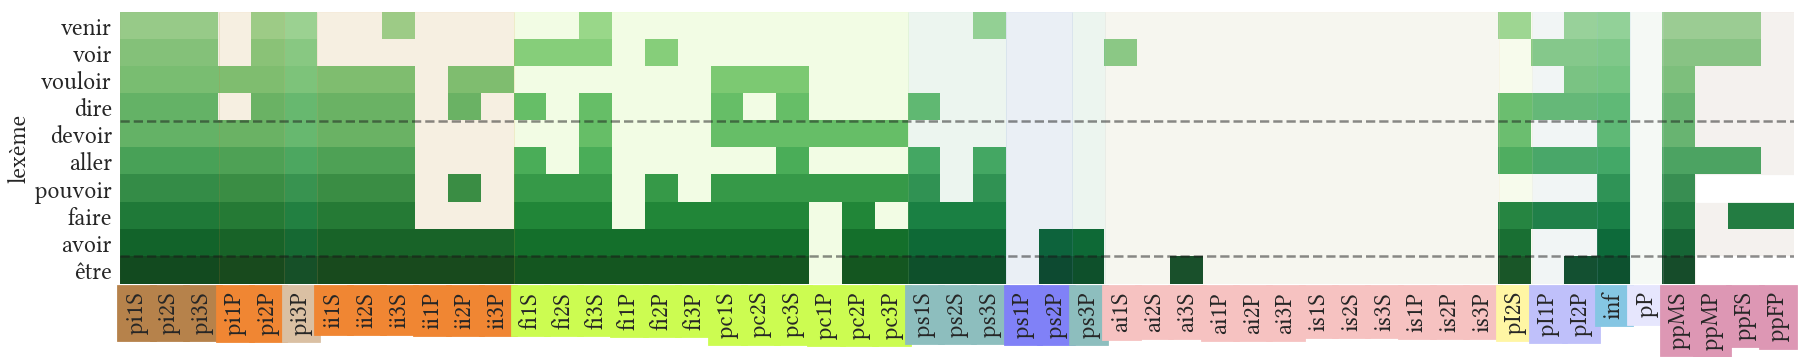

In [133]:
_, ax = plt.subplots(figsize=(30,h/float(2)))
ax=sns.heatmap(
                df,
#                 annot=True,
                ax=ax,
                cmap='Greens',
                cbar=False,
              )
colorerXTicks(ax,fSize=24,rot=90)
ylabels=ax.get_yticklabels()
ax.set_yticklabels(ylabels,size=24,
                   variant="small-caps",family=["Linux Libertine O","monospace"],
#                    rot=0,
                  )
ylabel=ax.get_ylabel()
ax.set_ylabel(ylabel,size=24,
                   variant="small-caps",family=["Linux Libertine O","monospace"],
#                    rot=0,
                  )
fig = plt.gcf()
etMap={
    3:cellColors["pi1S"],
    5:cellColors["pi1P"],
    6:cellColors["pi3P"],
    12:cellColors["ii1S"],
    24:cellColors["fi1S"],
    27:cellColors["ps1S"],
    29:cellColors["ps1P"],
    30:cellColors["ps3P"],
    42:cellColors["ai1S"],
    43:cellColors["pI2S"],
    45:cellColors["pI1P"],
    46:cellColors["inf"],
    47:cellColors["pP"],
    51:cellColors["ppMS"],
}
prevCol=0
rect={}
for l in [3,5,6,12,24,27,29,30,42,43,45,46,47,51]:
#     line=plt.Line2D((l,l),(0,h),color="k",alpha=0.5,linestyle=":")
#     fig.gca().add_artist(line)
    rect=plt.Rectangle((prevCol,0),l-prevCol,h,alpha=0.1,color=etMap[l])
    fig.gca().add_artist(rect)
    prevCol=l
for l in range(4,h,5):
    line=plt.Line2D((0,51),(l,l),color="k",alpha=0.5,linestyle="--")
    fig.gca().add_artist(line)

for l in [n for n,v in enumerate(df.index.tolist()) if v in noPP]:
    rect=plt.Rectangle((48,l),51,1,alpha=1,color="w")
    fig.gca().add_artist(rect)

# for case in [mC for mC in cfSet[cfVerbe].split(",") if mC!=""]:
#     l=cases.index(case)
#     print case,l
#     rect=plt.Rectangle((l,0),1,h,alpha=1,color="red")
#     fig.gca().add_artist(rect)
    
    
display(HTML('<a id="ParadigmesHF-Heatmap-MSP"></a>')) #bookmark for internal links

plt.savefig(repFigs+u'Lex4β-Heatmap-Freq%dFormes-Cut%d-Couverture.pdf'%(nbVerbesHF,seuilParHF), dpi=300, bbox_inches="tight")
print u'Lex4β-Heatmap-Freq%dFormes-Cut%d-Couverture.pdf'%(nbVerbesHF,seuilParHF)

Liens :
- [Paradigmes HF](#ParadigmesHF)
- [Résultat MSP](#ParadigmesHF-Heatmap-MSP)
- [Résultat OMP](#ParadigmesHF-Heatmap-OMP)

In [134]:
# for v in paradigmesHF:
dfV=dfL4["VFiltre"]
latexLignes={}
for v in paradigmesHF:
    l=v[u"lexème"]
    print l,len(v)-1
    vParTemp=[]
    for case in cases:
        if case in v:
#             print case
#             f=dfV.loc[(dfV.lemme.str.encode("utf8")==l.encode("utf8"))&(dfV.case==case),"graphie"].values
            f=dfFlexiqueIPA.loc[dfFlexiqueIPA.lexeme.str.encode("utf8")==l.encode("utf8"),case].values
            if f==f:
                f=[el.replace(u"E",u"ɛ").replace(u"Ø",u"ø") for el in f]
    #             print f
                vParTemp.extend(f)
    nbFormsParTemp=len(set(vParTemp))
    if nbFormsParTemp not in latexLignes:
        latexLignes[nbFormsParTemp]=[]
    latexLignes[nbFormsParTemp].append(ur"\item \textsc{%s} (%d) : "%(l,len(set(vParTemp))))
    latexLignes[nbFormsParTemp].append(", ".join(sorted(set(vParTemp))))

latexItemize=ur"\begin{itemize}"+"\n"+"\n".join(["\n".join(latexLignes[n]) for n in sorted(latexLignes,reverse=True)])+"\n"+ur"\end{itemize}"+"\n"
print latexItemize
pyperclip.copy(latexItemize)

venir 14
voir 16
vouloir 17
dire 19
devoir 19
aller 21
pouvoir 24
faire 28
avoir 31
être 33
\begin{itemize}
\item \textsc{être} (18) : 
fy, swa, swaje, sɔm, sɔ̃, səʁa, səʁe, səʁje, səʁɔ̃, səʁɛ, sɥi, ɛ, ɛt, ɛte, ɛtje, ɛtjɔ̃, ɛtɛ, ɛtʁ
\item \textsc{avoir} (16) : 
a, ave, avje, avjɔ̃, avwaʁ, avɔ̃, avɛ, oʁa, oʁe, oʁje, oʁɔ̃, oʁɛ, y, ɔ̃, ɛ, ɛje
\item \textsc{pouvoir} (14) : 
puve, puvje, puvwaʁ, puvɔ̃, puvɛ, puʁa, puʁe, puʁje, puʁjɔ̃, puʁɛ, py, pø, pœv, pɥis
\item \textsc{faire} (12) : 
fas, fɔ̃, fəzɔ̃, fəzɛ, fəʁa, fəʁe, fəʁje, fəʁɔ̃, fəʁɛ, fɛ, fɛt, fɛʁ
\item \textsc{devoir} (11) : 
dwa, dwav, dy, dəve, dəvwaʁ, dəvɔ̃, dəvɛ, dəvʁa, dəvʁije, dəvʁijɔ̃, dəvʁɛ
\item \textsc{vouloir} (10) : 
vudʁɛ, vule, vulje, vulwaʁ, vuly, vulɔ̃, vulɛ, vø, vøje, vœl
\item \textsc{aller} (10) : 
aj, ale, aleʁ, alɔ̃, alɛ, iʁa, iʁɛ, va, vɔ̃, vɛ
\item \textsc{voir} (9) : 
vi, vwa, vwaje, vwajɔ̃, vwaʁ, vy, vɛʁa, vɛʁe, vɛʁɛ
\item \textsc{dire} (9) : 
di, dit, diz, dizje, dizɔ̃, dizɛ, diʁ, diʁa, diʁɛ
\item \textsc{ven

Liens :
- [ParadigmesHF](#ParadigmesHF)

In [135]:
casesOmpBS={
 'pi2S':"pi3S",
 'ii1S':"ii3S",
 'ii2S':"ii3S",
 'ii3P':"ii3S",
 'fi1S':"fi2P",
 'fi2S':"fi3S",
 'fi3P':"fi1P",
 'pc1S':"pc3S",
 'pc2S':"pc3S",
 'pc3P':"pc3S",
 'ps1S':"ps3S",
 'ps2S':"ps3S",
 'ps3P':"ps3S",
 'ai2S':"ai3S",
 'is1S':"is2S",
 'is3S':"ai3S",
 'is3P':"is2S",
 'ppMP':"ppMS",
 'ppFP':"ppFS"
            }
for case in cases:
    if case not in casesOmpBS : casesOmpBS[case]=case

In [136]:
%store -r casesOmpBS

In [137]:
paradigmesHF

[{u'fi3S': 14,
  u'ii3S': 14,
  u'inf': 14,
  u'lex\xe8me': u'venir',
  u'pI2P': 14,
  u'pI2S': 14,
  u'pi1S': 14,
  u'pi2P': 14,
  u'pi2S': 14,
  u'pi3P': 14,
  u'pi3S': 14,
  u'ppFS': 14,
  u'ppMP': 14,
  u'ppMS': 14,
  u'ps3S': 14},
 {u'ai1S': 16,
  u'fi1S': 16,
  u'fi2P': 16,
  u'fi2S': 16,
  u'fi3S': 16,
  u'inf': 16,
  u'lex\xe8me': u'voir',
  u'pI1P': 16,
  u'pI2P': 16,
  u'pi1S': 16,
  u'pi2P': 16,
  u'pi2S': 16,
  u'pi3P': 16,
  u'pi3S': 16,
  u'ppFS': 16,
  u'ppMP': 16,
  u'ppMS': 16},
 {u'ii1S': 17,
  u'ii2P': 17,
  u'ii2S': 17,
  u'ii3P': 17,
  u'ii3S': 17,
  u'inf': 17,
  u'lex\xe8me': u'vouloir',
  u'pI2P': 17,
  u'pc1S': 17,
  u'pc2S': 17,
  u'pc3S': 17,
  u'pi1P': 17,
  u'pi1S': 17,
  u'pi2P': 17,
  u'pi2S': 17,
  u'pi3P': 17,
  u'pi3S': 17,
  u'ppMS': 17},
 {u'fi1S': 19,
  u'fi3S': 19,
  u'ii1S': 19,
  u'ii2P': 19,
  u'ii2S': 19,
  u'ii3S': 19,
  u'inf': 19,
  u'lex\xe8me': u'dire',
  u'pI1P': 19,
  u'pI2P': 19,
  u'pI2S': 19,
  u'pc1S': 19,
  u'pc3S': 19,
  u'pi1S': 1

In [138]:
omParadigmes=[]

for v in paradigmesHF:
#     print v[u"lexème"]
    cKnown={}
    cKnown[u"lexème"]=v[u"lexème"]
    mKnown=set()
    knownCases=[c for c in v if c!=u"lexème"]
    for mC in knownCases:
        mKnown.add(casesOmpBS[mC])
#     print v, len(mKnown)
    for mM in mKnown:
        cKnown[mM]=len(mKnown)+25
    omParadigmes.append(cKnown)
omParadigmes

[{'fi3S': 37,
  'ii3S': 37,
  'inf': 37,
  u'lex\xe8me': u'venir',
  'pI2P': 37,
  'pI2S': 37,
  'pi1S': 37,
  'pi2P': 37,
  'pi3P': 37,
  'pi3S': 37,
  'ppFS': 37,
  'ppMS': 37,
  'ps3S': 37},
 {'ai1S': 37,
  'fi2P': 37,
  'fi3S': 37,
  'inf': 37,
  u'lex\xe8me': u'voir',
  'pI1P': 37,
  'pI2P': 37,
  'pi1S': 37,
  'pi2P': 37,
  'pi3P': 37,
  'pi3S': 37,
  'ppFS': 37,
  'ppMS': 37},
 {'ii2P': 36,
  'ii3S': 36,
  'inf': 36,
  u'lex\xe8me': u'vouloir',
  'pI2P': 36,
  'pc3S': 36,
  'pi1P': 36,
  'pi1S': 36,
  'pi2P': 36,
  'pi3P': 36,
  'pi3S': 36,
  'ppMS': 36},
 {'fi2P': 40,
  'fi3S': 40,
  'ii2P': 40,
  'ii3S': 40,
  'inf': 40,
  u'lex\xe8me': u'dire',
  'pI1P': 40,
  'pI2P': 40,
  'pI2S': 40,
  'pc3S': 40,
  'pi1S': 40,
  'pi2P': 40,
  'pi3P': 40,
  'pi3S': 40,
  'ppMS': 40,
  'ps3S': 40},
 {'fi3S': 38,
  'ii3S': 38,
  'inf': 38,
  u'lex\xe8me': u'devoir',
  'pI2S': 38,
  'pc1P': 38,
  'pc2P': 38,
  'pc3S': 38,
  'pi1P': 38,
  'pi1S': 38,
  'pi2P': 38,
  'pi3P': 38,
  'pi3S': 38,
  

In [154]:
df=pd.DataFrame(omParadigmes)
ompCols=list(set(casesOmpBS.values()))
print ompCols

inCases=df.columns
outCases=list(set(casesOmpBS)-set(inCases))
print outCases

df=pd.concat([df,pd.DataFrame(columns=outCases)],sort=False)


ompColsSort=[u"lexème"]+cases
ompColsSort


ompCols.sort(key=lambda x: ompColsSort.index(x))
print ompCols

df=df[[u"lexème"]+ompCols]
# df.set_index(u"lexème")

df=df.fillna(0).set_index(u"lexème")
df.index.names=[u"Lexèmes-Cut%d-Formes-RangFWV%d"%(seuilParHF,nbVerbesHF,)]
h=len(df.index)
w=len(df.columns)
print h,w
# df

['ii1P', 'pP', 'ai3S', 'ai3P', 'ai1P', 'ii3S', 'ps3S', 'inf', 'ps1P', 'ai1S', 'pi2P', 'ppFS', 'is2S', 'is2P', 'pI2S', 'fi2P', 'pI2P', 'ps2P', 'ai2P', 'pc2P', 'ii2P', 'pi1S', 'pi1P', 'pi3P', 'pi3S', 'ppMS', 'pc3S', 'pc1P', 'is1P', 'fi3S', 'fi1P', 'pI1P']
['ii1S', 'is2S', 'pP', 'ppMP', 'is3P', 'is3S', 'ai1P', 'ps3P', 'ii3P', 'ps1P', 'ps1S', 'ppFP', 'pi2S', 'is2P', 'fi2S', 'ps2S', 'ai2P', 'ai2S', 'pc2S', 'ii2S', 'pc3P', 'is1S', 'is1P', 'fi3P', 'ai3P', 'fi1S', 'pc1S']
['pi1S', 'pi3S', 'pi1P', 'pi2P', 'pi3P', 'ii3S', 'ii1P', 'ii2P', 'fi3S', 'fi1P', 'fi2P', 'pc3S', 'pc1P', 'pc2P', 'ps3S', 'ps1P', 'ps2P', 'ai1S', 'ai3S', 'ai1P', 'ai2P', 'ai3P', 'is2S', 'is1P', 'is2P', 'pI2S', 'pI1P', 'pI2P', 'inf', 'pP', 'ppMS', 'ppFS']
10 32


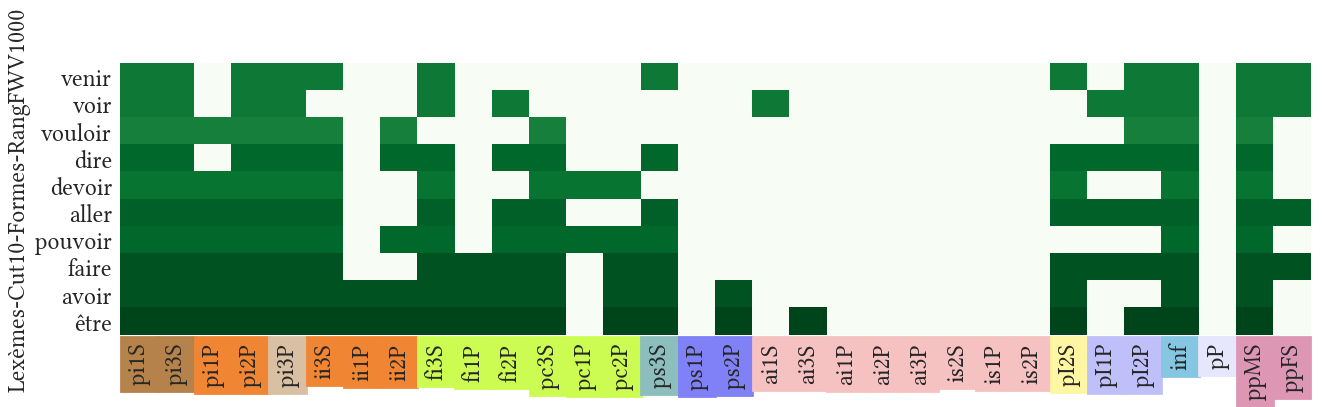

In [157]:
_, ax = plt.subplots(figsize=(w/float(1.5),h/float(2)))
ax=sns.heatmap(
                df,
#                 annot=True,
                ax=ax,
                cmap='Greens',
                cbar=False,
              )
colorerXTicks(ax,fSize=24,rot=90)
ylabels=ax.get_yticklabels()
ax.set_yticklabels(ylabels,size=24,
                   variant="small-caps",family=["Linux Libertine O","monospace"],
#                    rot=0,
                  )
ylabel=ax.get_ylabel()
ax.set_ylabel(ylabel,size=24,
                   variant="small-caps",family=["Linux Libertine O","monospace"],
#                    rot=0,
                  )
fig = plt.gcf()

display(HTML('<a id="ParadigmesHF-Heatmap-OMP"></a>')) #bookmark for internal links


plt.savefig(repFigs+u'Lex4β-Heatmap-OMP-Lexemes%d-FormesRangFWV%d.pdf'%(seuilParHF,nbVerbesHF,), dpi=300, bbox_inches="tight")

Liens :
- [Paradigmes HF](#ParadigmesHF)
- [Résultat MSP](#ParadigmesHF-Heatmap-MSP)
- [Résultat OMP](#ParadigmesHF-Heatmap-OMP)

,pi1S,pi3S,pi1P,pi2P,pi3P,ii3S,ii1P,ii2P,fi3S,fi1P,...,is2S,is1P,is2P,pI2S,pI1P,pI2P,inf,pP,ppMS,ppFS
Lexèmes-Cut10-Formes-RangFWV1000,,,,,,,,,,,,,,,,,,,,,
venir,37.0,37.0,0.0,37.0,37.0,37.0,0.0,0.0,37.0,0.0,...,0,0,0,37.0,0.0,37.0,37.0,0,37.0,37.0
voir,37.0,37.0,0.0,37.0,37.0,0.0,0.0,0.0,37.0,0.0,...,0,0,0,0.0,37.0,37.0,37.0,0,37.0,37.0
vouloir,36.0,36.0,36.0,36.0,36.0,36.0,0.0,36.0,0.0,0.0,...,0,0,0,0.0,0.0,36.0,36.0,0,36.0,0.0
dire,40.0,40.0,0.0,40.0,40.0,40.0,0.0,40.0,40.0,0.0,...,0,0,0,40.0,40.0,40.0,40.0,0,40.0,0.0
devoir,38.0,38.0,38.0,38.0,38.0,38.0,0.0,0.0,38.0,0.0,...,0,0,0,38.0,0.0,0.0,38.0,0,38.0,0.0
aller,41.0,41.0,41.0,41.0,41.0,41.0,0.0,0.0,41.0,0.0,...,0,0,0,41.0,41.0,41.0,41.0,0,41.0,41.0
pouvoir,40.0,40.0,40.0,40.0,40.0,40.0,0.0,40.0,40.0,0.0,...,0,0,0,0.0,0.0,0.0,40.0,0,40.0,0.0
faire,43.0,43.0,43.0,43.0,43.0,43.0,0.0,0.0,43.0,43.0,...,0,0,0,43.0,43.0,43.0,43.0,0,43.0,43.0
avoir,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,...,0,0,0,43.0,0.0,0.0,43.0,0,43.0,0.0


In [166]:
latexLignes={}
dataLignes={}
for v in omParadigmes:
    l=v[u"lexème"]
    print l,len(v)-1
    vParTemp={}
    dataLignes[l]=[]
    for case in cases:
        if case in v:
#             print case
#             f=dfV.loc[(dfV.lemme.str.encode("utf8")==l.encode("utf8"))&(dfV.case==case),"graphie"].values
            f=dfFlexiqueIPA.loc[dfFlexiqueIPA.lexeme.str.encode("utf8")==l.encode("utf8"),case].values
            if f==f:
                for fEl in [el.replace(u"E",u"ɛ").replace(u"Ø",u"ø") for el in f]:
                    if fEl not in vParTemp:
                        vParTemp[fEl]=[]
                    vParTemp[fEl].append(case)
    dataLignes[l]=vParTemp
    vParLigne=sorted([u"%s ("%k+",".join(v)+")" for k,v in vParTemp.iteritems()])
    nbFormsParTemp=len(set(vParTemp.keys()))
    if nbFormsParTemp not in latexLignes:
        latexLignes[nbFormsParTemp]=[]
    latexLignes[nbFormsParTemp].append(ur"\item \textsc{%s} (%d) : "%(l,len(set(vParTemp))))
    latexLignes[nbFormsParTemp].append(", ".join(vParLigne))
latexItemize=ur"\begin{itemize}"+"\n"+"\n".join(["\n".join(latexLignes[n]) for n in sorted(latexLignes,reverse=True)])+"\n"+ur"\end{itemize}"+"\n"
print latexItemize
pyperclip.copy(latexItemize)

venir 12
voir 12
vouloir 11
dire 15
devoir 13
aller 16
pouvoir 15
faire 18
avoir 18
être 20
\begin{itemize}
\item \textsc{être} (18) : 
fy (ai3S), swa (ps3S,pI2S), swaje (ps2P,pI2P), sɔm (pi1P), sɔ̃ (pi3P), səʁa (fi3S), səʁe (fi2P), səʁje (pc2P), səʁɔ̃ (fi1P), səʁɛ (pc3S), sɥi (pi1S), ɛ (pi3S), ɛt (pi2P), ɛte (ppMS), ɛtje (ii2P), ɛtjɔ̃ (ii1P), ɛtɛ (ii3S), ɛtʁ (inf)
\item \textsc{avoir} (16) : 
a (pi3S), ave (pi2P), avje (ii2P), avjɔ̃ (ii1P), avwaʁ (inf), avɔ̃ (pi1P), avɛ (ii3S), oʁa (fi3S), oʁe (fi2P), oʁje (pc2P), oʁɔ̃ (fi1P), oʁɛ (pc3S), y (ppMS), ɔ̃ (pi3P), ɛ (pi1S,ps3S,pI2S), ɛje (ps2P)
\item \textsc{pouvoir} (14) : 
puve (pi2P), puvje (ii2P), puvwaʁ (inf), puvɔ̃ (pi1P), puvɛ (ii3S), puʁa (fi3S), puʁe (fi2P), puʁje (pc2P), puʁjɔ̃ (pc1P), puʁɛ (pc3S), py (ppMS), pø (pi1S,pi3S), pœv (pi3P), pɥis (ps3S)
\item \textsc{faire} (12) : 
fas (ps3S), fɔ̃ (pi3P), fəzɔ̃ (pi1P,pI1P), fəzɛ (ii3S), fəʁa (fi3S), fəʁe (fi2P), fəʁje (pc2P), fəʁɔ̃ (fi1P), fəʁɛ (pc3S), fɛ (pi1S,pi3S,pI2S,ppMS), fɛt (p

In [194]:
omFormsPar=[]

for l in dataLignes:
    fKnown={}
    fKnown[u"lexème"]=l
#     print l
    for iF,f in enumerate(dataLignes[l]):
#         print iF,f,dataLignes[l][f]
        if len(dataLignes[l][f])>1:
            for cF in dataLignes[l][f]:
                fKnown[cF]=iF+1
        else:
            for cF in dataLignes[l][f]:
                fKnown[cF]=19
    omFormsPar.append(fKnown)
omFormsPar

[{'fi2P': 19,
  'fi3S': 19,
  'ii3S': 19,
  'inf': 19,
  u'lex\xe8me': u'aller',
  'pI1P': 7,
  'pI2P': 6,
  'pI2S': 1,
  'pc3S': 19,
  'pi1P': 7,
  'pi1S': 19,
  'pi2P': 6,
  'pi3P': 19,
  'pi3S': 1,
  'ppFS': 6,
  'ppMS': 6,
  'ps3S': 19},
 {'fi1P': 19,
  'fi2P': 19,
  'fi3S': 19,
  'ii3S': 19,
  'inf': 19,
  u'lex\xe8me': u'faire',
  'pI1P': 3,
  'pI2P': 5,
  'pI2S': 4,
  'pc2P': 19,
  'pc3S': 19,
  'pi1P': 3,
  'pi1S': 4,
  'pi2P': 5,
  'pi3P': 19,
  'pi3S': 4,
  'ppFS': 5,
  'ppMS': 4,
  'ps3S': 19},
 {'fi3S': 19,
  'ii3S': 19,
  'inf': 19,
  u'lex\xe8me': u'devoir',
  'pI2S': 8,
  'pc1P': 19,
  'pc2P': 19,
  'pc3S': 19,
  'pi1P': 19,
  'pi1S': 8,
  'pi2P': 19,
  'pi3P': 19,
  'pi3S': 8,
  'ppMS': 19},
 {'fi1P': 19,
  'fi2P': 19,
  'fi3S': 19,
  'ii1P': 19,
  'ii2P': 19,
  'ii3S': 19,
  'inf': 19,
  u'lex\xe8me': u'avoir',
  'pI2S': 13,
  'pc2P': 19,
  'pc3S': 19,
  'pi1P': 19,
  'pi1S': 13,
  'pi2P': 19,
  'pi3P': 19,
  'pi3S': 19,
  'ppMS': 19,
  'ps2P': 19,
  'ps3S': 13},
 {'ii

In [195]:
df=pd.DataFrame(omFormsPar)
ompCols=list(set(casesOmpBS.values()))
print ompCols

inCases=df.columns
outCases=list(set(casesOmpBS)-set(inCases))
print outCases

df=pd.concat([df,pd.DataFrame(columns=outCases)],sort=False)


ompColsSort=[u"lexème"]+cases
ompColsSort


ompCols.sort(key=lambda x: ompColsSort.index(x))
print ompCols

df=df[[u"lexème"]+ompCols]
# df.set_index(u"lexème")

df=df.fillna(0).set_index(u"lexème")
df.index.names=[u"Lexèmes-Cut%d-Formes-RangFWV%d"%(seuilParHF,nbVerbesHF,)]
h=len(df.index)
w=len(df.columns)
print h,w
# df

['ii1P', 'pP', 'ai3S', 'ai3P', 'ai1P', 'ii3S', 'ps3S', 'inf', 'ps1P', 'ai1S', 'pi2P', 'ppFS', 'is2S', 'is2P', 'pI2S', 'fi2P', 'pI2P', 'ps2P', 'ai2P', 'pc2P', 'ii2P', 'pi1S', 'pi1P', 'pi3P', 'pi3S', 'ppMS', 'pc3S', 'pc1P', 'is1P', 'fi3S', 'fi1P', 'pI1P']
['ii1S', 'is2S', 'pP', 'ppMP', 'is3P', 'is3S', 'ai1P', 'ps3P', 'ii3P', 'ps1P', 'ps1S', 'ppFP', 'pi2S', 'is2P', 'fi2S', 'ps2S', 'ai2P', 'ai2S', 'pc2S', 'ii2S', 'pc3P', 'is1S', 'is1P', 'fi3P', 'ai3P', 'fi1S', 'pc1S']
['pi1S', 'pi3S', 'pi1P', 'pi2P', 'pi3P', 'ii3S', 'ii1P', 'ii2P', 'fi3S', 'fi1P', 'fi2P', 'pc3S', 'pc1P', 'pc2P', 'ps3S', 'ps1P', 'ps2P', 'ai1S', 'ai3S', 'ai1P', 'ai2P', 'ai3P', 'is2S', 'is1P', 'is2P', 'pI2S', 'pI1P', 'pI2P', 'inf', 'pP', 'ppMS', 'ppFS']
10 32


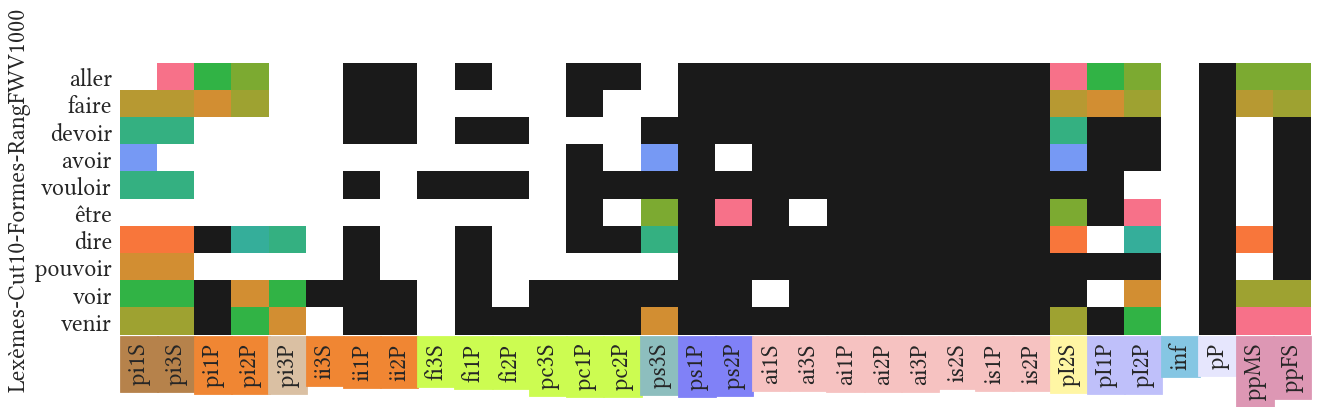

In [197]:
_, ax = plt.subplots(figsize=(w/float(1.5),h/float(2)))
ax=sns.heatmap(
                df,
#                 annot=True,
                ax=ax,
                cmap=["k"]+sns.husl_palette(17)+["w"],
                cbar=False,
              )
colorerXTicks(ax,fSize=24,rot=90)
ylabels=ax.get_yticklabels()
ax.set_yticklabels(ylabels,size=24,
                   variant="small-caps",family=["Linux Libertine O","monospace"],
#                    rot=0,
                  )
ylabel=ax.get_ylabel()
ax.set_ylabel(ylabel,size=24,
                   variant="small-caps",family=["Linux Libertine O","monospace"],
#                    rot=0,
                  )
fig = plt.gcf()

display(HTML('<a id="ParadigmesHF-Heatmap-OMP"></a>')) #bookmark for internal links


plt.savefig(repFigs+u'Lex4β-Heatmap-OMP-Formes-Lexemes%d-FormesRangFWV%d.pdf'%(seuilParHF,nbVerbesHF,), dpi=300, bbox_inches="tight")